# Benchmarking Modèles ML - Prédiction Consommation RTE

Ce notebook compare plusieurs algorithmes ML pour prédire la consommation électrique française.

---

## 1. Imports et configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Modèles à comparer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Imports OK")

Imports OK


## 2. Chargement et préparation des données

In [2]:
# Charger données
data_path = Path('../data/conso_recent_2026.csv')
df = pd.read_csv(data_path)

print(f"Données chargées : {len(df)} enregistrements")
df.head()

Données chargées : 168 enregistrements


,date_heure,consommation,prevision_j
0,2025-01-09 15:00:00+00:00,63066,62700
1,2025-01-09 15:15:00+00:00,62949,63000
2,2025-01-09 15:30:00+00:00,63348,63300
3,2025-01-09 15:45:00+00:00,63364,63650
4,2025-01-09 16:00:00+00:00,64135,64000


In [3]:
# Feature engineering
df['date_heure'] = pd.to_datetime(df['date_heure'])
df['heure'] = df['date_heure'].dt.hour
df['jour_semaine'] = df['date_heure'].dt.dayofweek
df['mois'] = df['date_heure'].dt.month
df['jour_mois'] = df['date_heure'].dt.day
df['weekend'] = (df['jour_semaine'] >= 5).astype(int)

# Nettoyage
df_clean = df.dropna(subset=['consommation'])

print(f"Données nettoyées : {len(df_clean)} enregistrements")
print(f"\nFeatures disponibles : {df_clean.columns.tolist()}")

Données nettoyées : 168 enregistrements

Features disponibles : ['date_heure', 'consommation', 'prevision_j', 'heure', 'jour_semaine', 'mois', 'jour_mois', 'weekend']


In [4]:
# Préparer features et target
features = ['heure', 'jour_semaine', 'mois', 'jour_mois', 'weekend']
target = 'consommation'

X = df_clean[features]
y = df_clean[target]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train set : {len(X_train)} samples")
print(f"Test set  : {len(X_test)} samples")
print(f"\nFeatures utilisées : {features}")

Train set : 134 samples
Test set  : 34 samples

Features utilisées : ['heure', 'jour_semaine', 'mois', 'jour_mois', 'weekend']


## 3. Définition des modèles à comparer

In [5]:
# Dictionnaire des modèles avec hyperparamètres
models = {
    'RandomForest': RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': XGBRegressor(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        random_state=42
    ),
    'ExtraTrees': ExtraTreesRegressor(
        n_estimators=200,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    ),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'KNeighbors': KNeighborsRegressor(n_neighbors=10, n_jobs=-1)
}

print(f"Nombre de modèles à comparer : {len(models)}")
print(f"\nModèles : {list(models.keys())}")

Nombre de modèles à comparer : 8

Modèles : ['RandomForest', 'XGBoost', 'GradientBoosting', 'ExtraTrees', 'LinearRegression', 'Ridge', 'Lasso', 'KNeighbors']


## 4. Benchmarking - Entraînement et évaluation

In [6]:
# Fonction d'évaluation
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Entraîne et évalue un modèle"""
    
    print(f"\n{'='*60}")
    print(f"Modèle : {model_name}")
    print(f"{'='*60}")
    
    # Entraînement
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Prédictions
    start_time = time.time()
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    pred_time = time.time() - start_time
    
    # Métriques
    results = {
        'model': model_name,
        'train_time_s': round(train_time, 3),
        'pred_time_s': round(pred_time, 3),
        
        # Train metrics
        'train_mae': round(mean_absolute_error(y_train, y_pred_train), 2),
        'train_rmse': round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 2),
        'train_r2': round(r2_score(y_train, y_pred_train), 4),
        
        # Test metrics
        'test_mae': round(mean_absolute_error(y_test, y_pred_test), 2),
        'test_rmse': round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 2),
        'test_r2': round(r2_score(y_test, y_pred_test), 4),
        
        # MAPE
        'test_mape': round(np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100, 2)
    }
    
    # Cross-validation
    cv_scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    results['cv_mae'] = round(-cv_scores.mean(), 2)
    results['cv_mae_std'] = round(cv_scores.std(), 2)
    
    # Affichage
    print(f"\nTemps entraînement : {results['train_time_s']}s")
    print(f"Temps prédiction   : {results['pred_time_s']}s")
    print(f"\nPerformances TRAIN :")
    print(f"  MAE  : {results['train_mae']:>8,.0f} MW")
    print(f"  RMSE : {results['train_rmse']:>8,.0f} MW")
    print(f"  R²   : {results['train_r2']:>8.4f}")
    print(f"\nPerformances TEST :")
    print(f"  MAE  : {results['test_mae']:>8,.0f} MW")
    print(f"  RMSE : {results['test_rmse']:>8,.0f} MW")
    print(f"  R²   : {results['test_r2']:>8.4f}")
    print(f"  MAPE : {results['test_mape']:>8.2f} %")
    print(f"\nCross-Validation (5-fold) :")
    print(f"  MAE  : {results['cv_mae']:>8,.0f} MW (+/- {results['cv_mae_std']:.0f})")
    
    return results

print("Fonction d'évaluation définie")

Fonction d'évaluation définie


In [7]:
# Lancer le benchmarking
print("DÉBUT DU BENCHMARKING")
print("="*60)

all_results = []

for model_name, model in models.items():
    try:
        results = evaluate_model(model, X_train, X_test, y_train, y_test, model_name)
        all_results.append(results)
    except Exception as e:
        print(f"\nERREUR avec {model_name}: {str(e)}")
        continue

print("\n" + "="*60)
print("BENCHMARKING TERMINÉ")
print("="*60)

DÉBUT DU BENCHMARKING

Modèle : RandomForest

Temps entraînement : 0.104s
Temps prédiction   : 0.028s

Performances TRAIN :
  MAE  :      588 MW
  RMSE :      784 MW
  R²   :   0.9802

Performances TEST :
  MAE  :      758 MW
  RMSE :      939 MW
  R²   :   0.9736
  MAPE :     1.20 %

Cross-Validation (5-fold) :
  MAE  :      935 MW (+/- 217)

Modèle : XGBoost

Temps entraînement : 0.352s
Temps prédiction   : 0.003s

Performances TRAIN :
  MAE  :      489 MW
  RMSE :      653 MW
  R²   :   0.9862

Performances TEST :
  MAE  :      780 MW
  RMSE :    1,036 MW
  R²   :   0.9678
  MAPE :     1.23 %

Cross-Validation (5-fold) :
  MAE  :      760 MW (+/- 112)

Modèle : GradientBoosting

Temps entraînement : 0.028s
Temps prédiction   : 0.001s

Performances TRAIN :
  MAE  :      489 MW
  RMSE :      653 MW
  R²   :   0.9862

Performances TEST :
  MAE  :      780 MW
  RMSE :    1,036 MW
  R²   :   0.9678
  MAPE :     1.23 %

Cross-Validation (5-fold) :
  MAE  :      750 MW (+/- 123)

Modèle : 

## 5. Tableau comparatif des résultats

In [8]:
# Créer DataFrame des résultats
df_results = pd.DataFrame(all_results)

# Trier par MAE test (meilleur en premier)
df_results = df_results.sort_values('test_mae')

# Afficher tableau complet
print("\n" + "="*80)
print("TABLEAU RÉCAPITULATIF - BENCHMARKING MODÈLES ML")
print("="*80 + "\n")

display(df_results)

# Identifier le meilleur modèle
best_model = df_results.iloc[0]
print(f"\n🏆 MEILLEUR MODÈLE : {best_model['model']}")
print(f"   MAE  : {best_model['test_mae']:,.0f} MW")
print(f"   R²   : {best_model['test_r2']:.4f}")
print(f"   MAPE : {best_model['test_mape']:.2f}%")
print(f"   Temps: {best_model['train_time_s']:.2f}s")


TABLEAU RÉCAPITULATIF - BENCHMARKING MODÈLES ML



,model,train_time_s,pred_time_s,train_mae,train_rmse,train_r2,test_mae,test_rmse,test_r2,test_mape,cv_mae,cv_mae_std
0,RandomForest,0.104,0.028,588.40,783.56,0.9802,758.11,938.72,0.9736,1.20,934.79,216.72
1,XGBoost,0.352,0.003,488.55,653.38,0.9862,779.97,1036.11,0.9678,1.23,759.77,112.47
2,GradientBoosting,0.028,0.001,488.55,653.38,0.9862,779.97,1036.12,0.9678,1.23,749.58,123.03
3,ExtraTrees,0.057,0.028,488.55,653.38,0.9862,779.97,1036.12,0.9678,1.23,780.63,107.59
7,KNeighbors,0.001,0.026,800.62,990.79,0.9684,980.24,1227.93,0.9548,1.52,1294.01,176.40
5,Ridge,0.005,0.000,3722.26,4454.48,0.3608,3975.51,4524.37,0.3864,6.13,3858.24,530.66
6,Lasso,0.002,0.000,3695.82,4448.03,0.3626,3983.84,4532.38,0.3842,6.15,3823.64,515.68
4,LinearRegression,0.012,0.001,3695.11,4448.02,0.3626,3983.95,4532.59,0.3841,6.15,3822.96,515.36



🏆 MEILLEUR MODÈLE : RandomForest
   MAE  : 758 MW
   R²   : 0.9736
   MAPE : 1.20%
   Temps: 0.10s


In [9]:
# Tableau simplifié pour présentation
df_simple = df_results[[
    'model', 'test_mae', 'test_r2', 'test_mape',
    'train_time_s', 'cv_mae'
]].copy()

df_simple.columns = ['Modèle', 'MAE (MW)', 'R²', 'MAPE (%)', 'Temps (s)', 'CV MAE (MW)']

print("\nTABLEAU SIMPLIFIÉ :")
print("="*80)
display(df_simple.style.format({
    'MAE (MW)': '{:,.0f}',
    'R²': '{:.4f}',
    'MAPE (%)': '{:.2f}',
    'Temps (s)': '{:.2f}',
    'CV MAE (MW)': '{:,.0f}'
}).background_gradient(subset=['MAE (MW)'], cmap='RdYlGn_r'))


TABLEAU SIMPLIFIÉ :


,Modèle,MAE (MW),R²,MAPE (%),Temps (s),CV MAE (MW)
0,RandomForest,758,0.9736,1.20,0.10,935
1,XGBoost,780,0.9678,1.23,0.35,760
2,GradientBoosting,780,0.9678,1.23,0.03,750
3,ExtraTrees,780,0.9678,1.23,0.06,781
7,KNeighbors,980,0.9548,1.52,0.00,"1,294"
5,Ridge,"3,976",0.3864,6.13,0.01,"3,858"
6,Lasso,"3,984",0.3842,6.15,0.00,"3,824"
4,LinearRegression,"3,984",0.3841,6.15,0.01,"3,823"


## 6. Visualisations comparatives

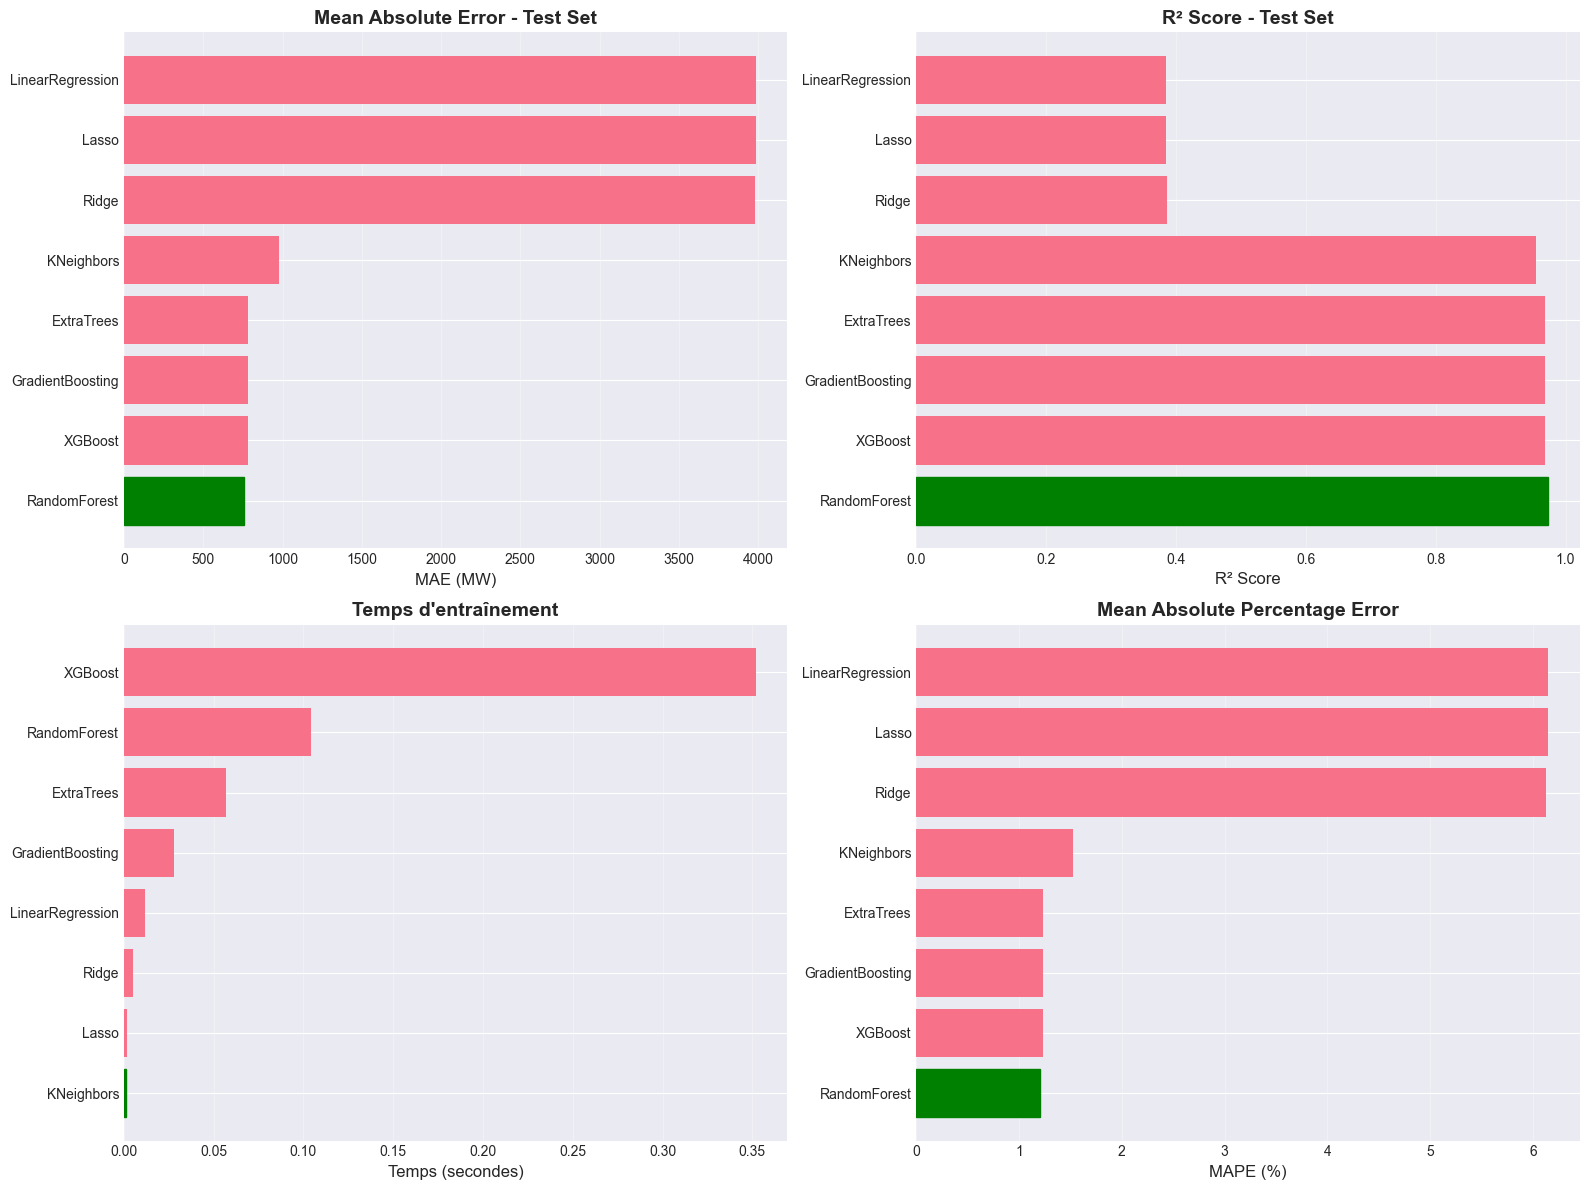

Graphique sauvegardé : benchmark_results.png


In [10]:
# Graphique 1 : Comparaison MAE
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# MAE Test
ax1 = axes[0, 0]
df_results_sorted = df_results.sort_values('test_mae')
bars1 = ax1.barh(df_results_sorted['model'], df_results_sorted['test_mae'])
bars1[0].set_color('green')
ax1.set_xlabel('MAE (MW)', fontsize=12)
ax1.set_title('Mean Absolute Error - Test Set', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# R² Score
ax2 = axes[0, 1]
df_results_sorted = df_results.sort_values('test_r2', ascending=False)
bars2 = ax2.barh(df_results_sorted['model'], df_results_sorted['test_r2'])
bars2[0].set_color('green')
ax2.set_xlabel('R² Score', fontsize=12)
ax2.set_title('R² Score - Test Set', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Temps d'entraînement
ax3 = axes[1, 0]
df_results_sorted = df_results.sort_values('train_time_s')
bars3 = ax3.barh(df_results_sorted['model'], df_results_sorted['train_time_s'])
bars3[0].set_color('green')
ax3.set_xlabel('Temps (secondes)', fontsize=12)
ax3.set_title('Temps d\'entraînement', fontsize=14, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# MAPE
ax4 = axes[1, 1]
df_results_sorted = df_results.sort_values('test_mape')
bars4 = ax4.barh(df_results_sorted['model'], df_results_sorted['test_mape'])
bars4[0].set_color('green')
ax4.set_xlabel('MAPE (%)', fontsize=12)
ax4.set_title('Mean Absolute Percentage Error', fontsize=14, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('benchmark_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graphique sauvegardé : benchmark_results.png")

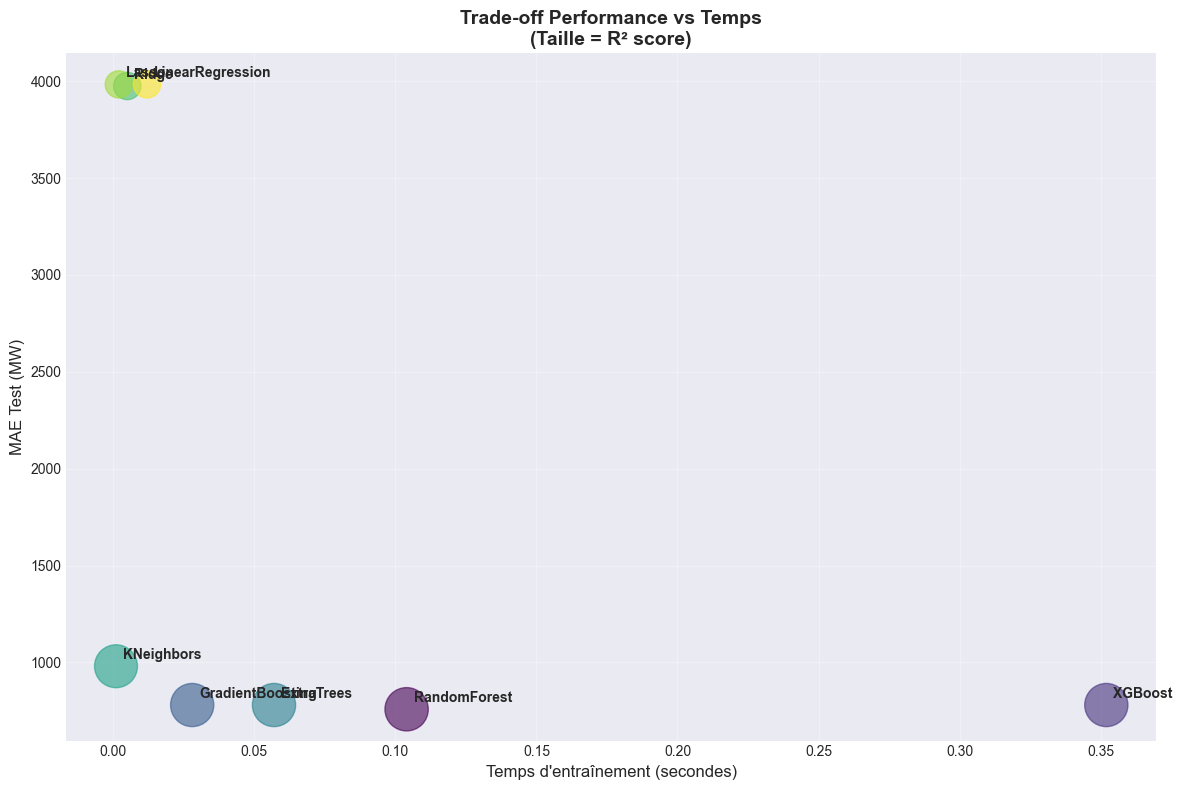

Graphique sauvegardé : tradeoff_performance_time.png


In [11]:
# Graphique 2 : Performance vs Temps (trade-off)
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    df_results['train_time_s'],
    df_results['test_mae'],
    s=df_results['test_r2']*1000,
    alpha=0.6,
    c=range(len(df_results)),
    cmap='viridis'
)

# Annoter chaque point
for idx, row in df_results.iterrows():
    ax.annotate(
        row['model'],
        (row['train_time_s'], row['test_mae']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold'
    )

ax.set_xlabel('Temps d\'entraînement (secondes)', fontsize=12)
ax.set_ylabel('MAE Test (MW)', fontsize=12)
ax.set_title('Trade-off Performance vs Temps\n(Taille = R² score)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('tradeoff_performance_time.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graphique sauvegardé : tradeoff_performance_time.png")

## 7. Analyse détaillée du meilleur modèle

Analyse détaillée du meilleur modèle : RandomForest

Importance des features :


,feature,importance
0,heure,0.894548
3,jour_mois,0.039540
1,jour_semaine,0.035802
4,weekend,0.030111
2,mois,0.000000


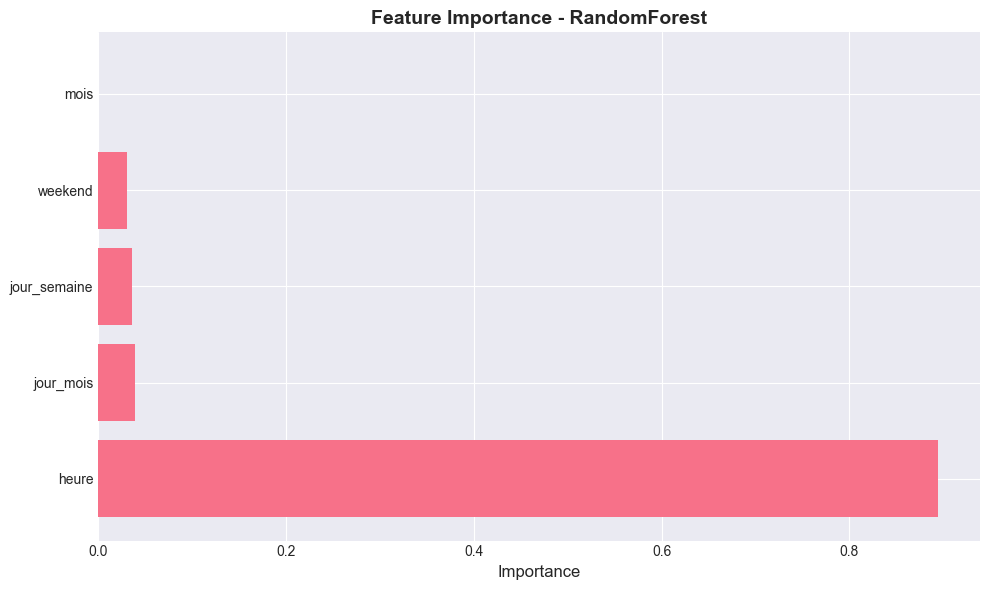

Graphique sauvegardé : feature_importance.png


In [12]:
# Ré-entraîner le meilleur modèle
best_model_name = df_results.iloc[0]['model']
best_model_obj = models[best_model_name]

print(f"Analyse détaillée du meilleur modèle : {best_model_name}")
print("="*60)

best_model_obj.fit(X_train, y_train)
y_pred_best = best_model_obj.predict(X_test)

# Feature importance (si disponible)
if hasattr(best_model_obj, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': best_model_obj.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nImportance des features :")
    display(feature_importance)
    
    # Graphique feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Graphique sauvegardé : feature_importance.png")

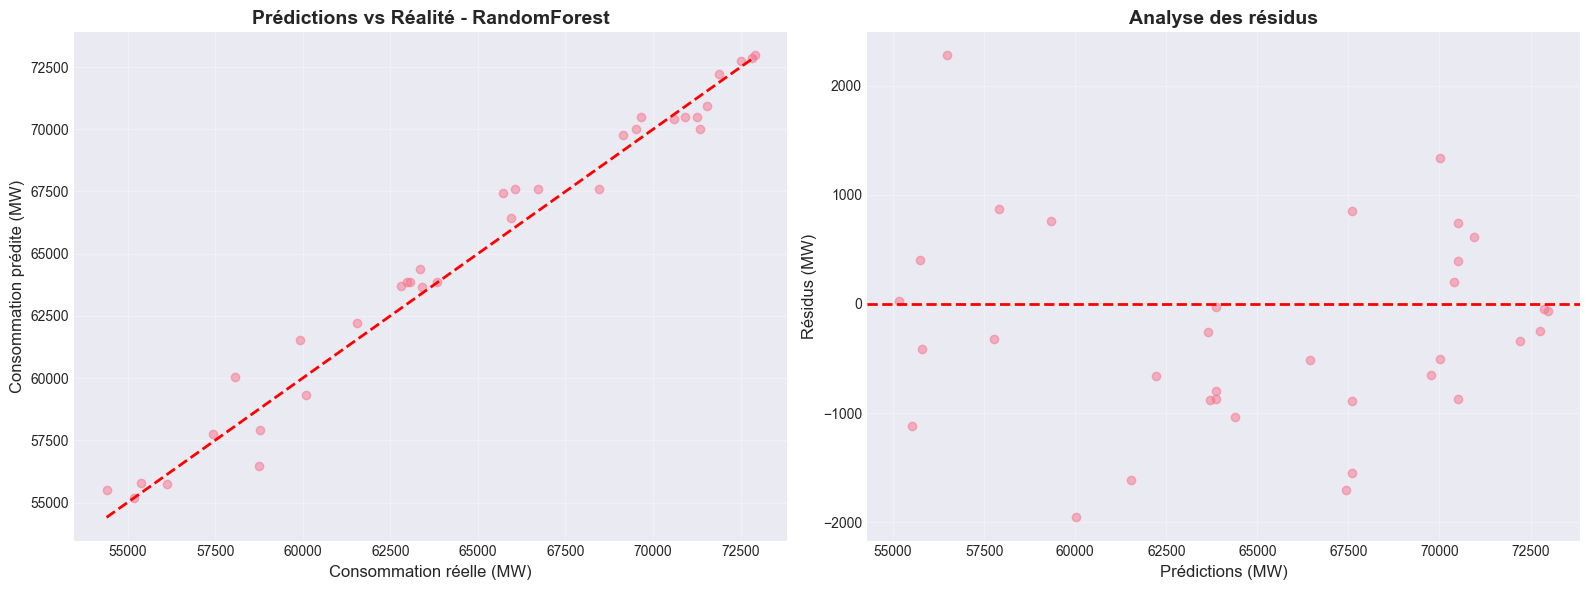

Graphique sauvegardé : predictions_analysis.png


In [13]:
# Graphique prédictions vs réalité
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
ax1 = axes[0]
ax1.scatter(y_test, y_pred_best, alpha=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Consommation réelle (MW)', fontsize=12)
ax1.set_ylabel('Consommation prédite (MW)', fontsize=12)
ax1.set_title(f'Prédictions vs Réalité - {best_model_name}', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# Résidus
ax2 = axes[1]
residuals = y_test - y_pred_best
ax2.scatter(y_pred_best, residuals, alpha=0.5)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Prédictions (MW)', fontsize=12)
ax2.set_ylabel('Résidus (MW)', fontsize=12)
ax2.set_title('Analyse des résidus', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('predictions_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graphique sauvegardé : predictions_analysis.png")

## 8. Conclusions et recommandations

In [ ]:
print("="*80)
print("CONCLUSIONS DU BENCHMARKING")
print("="*80)

# Top 3 modèles
top3 = df_results.head(3)

print("\n🥇 TOP 3 MODÈLES :")
print("-" * 80)
for idx, (i, row) in enumerate(top3.iterrows(), 1):
    print(f"{idx}. {row['model']:<20} | MAE: {row['test_mae']:>7,.0f} MW | R²: {row['test_r2']:.4f} | Temps: {row['train_time_s']:>5.2f}s")

# Analyse comparative
best = df_results.iloc[0]
worst = df_results.iloc[-1]

improvement = ((worst['test_mae'] - best['test_mae']) / worst['test_mae']) * 100

print(f"\n ANALYSE :")
print("-" * 80)
print(f"Meilleur modèle : {best['model']}")
print(f"Amélioration vs pire modèle : {improvement:.1f}%")
print(f"MAE du meilleur : {best['test_mae']:,.0f} MW")
print(f"MAE du pire : {worst['test_mae']:,.0f} MW")

print(f"\n RECOMMANDATIONS :")
print("-" * 80)

# Recommandation selon performance
if best['model'] in ['XGBoost', 'GradientBoosting']:
    print("✓ Modèles de boosting performent mieux pour ce problème")
    print("✓ Considérer l'optimisation des hyperparamètres (grid search)")
    print("✓ Trade-off temps/performance acceptable pour production")
elif best['model'] == 'RandomForest':
    print("✓ RandomForest offre un bon équilibre performance/simplicité")
    print("✓ Parallélisation efficace (n_jobs=-1)")
    print("✓ Robuste au surapprentissage")

# Trade-off temps
fastest = df_results.loc[df_results['train_time_s'].idxmin()]
if fastest['model'] != best['model']:
    print(f"\n⚡ Modèle le plus rapide : {fastest['model']} ({fastest['train_time_s']:.2f}s)")
    print(f"   Différence MAE : +{fastest['test_mae'] - best['test_mae']:.0f} MW")

print("\n" + "="*80)

CONCLUSIONS DU BENCHMARKING

🥇 TOP 3 MODÈLES :
--------------------------------------------------------------------------------
1. RandomForest         | MAE:     758 MW | R²: 0.9736 | Temps:  0.10s
2. XGBoost              | MAE:     780 MW | R²: 0.9678 | Temps:  0.35s
3. GradientBoosting     | MAE:     780 MW | R²: 0.9678 | Temps:  0.03s

📊 ANALYSE :
--------------------------------------------------------------------------------
Meilleur modèle : RandomForest
Amélioration vs pire modèle : 81.0%
MAE du meilleur : 758 MW
MAE du pire : 3,984 MW

💡 RECOMMANDATIONS :
--------------------------------------------------------------------------------
✓ RandomForest offre un bon équilibre performance/simplicité
✓ Parallélisation efficace (n_jobs=-1)
✓ Robuste au surapprentissage

⚡ Modèle le plus rapide : KNeighbors (0.00s)
   Différence MAE : +222 MW



## 9. Export des résultats

In [15]:
# Sauvegarder résultats en CSV
df_results.to_csv('benchmark_results.csv', index=False)
print("Résultats sauvegardés : benchmark_results.csv")

# Sauvegarder résumé en JSON
import json

summary = {
    'date_benchmark': pd.Timestamp.now().isoformat(),
    'nb_models': len(models),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'features': features,
    'best_model': {
        'name': best['model'],
        'test_mae': float(best['test_mae']),
        'test_r2': float(best['test_r2']),
        'test_mape': float(best['test_mape']),
        'train_time_s': float(best['train_time_s'])
    },
    'all_results': df_results.to_dict('records')
}

with open('benchmark_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("Résumé sauvegardé : benchmark_summary.json")
print("\n BENCHMARKING COMPLET TERMINÉ")

Résultats sauvegardés : benchmark_results.csv
Résumé sauvegardé : benchmark_summary.json

 BENCHMARKING COMPLET TERMINÉ


Exception ignored in: <function ResourceTracker.__del__ at 0x10b975c60>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.12/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.12/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.12/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10753dc60>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.12/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.12/Frameworks/Python.framework/